In [2]:
%matplotlib inline
%reset
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skrf as rf # scikit-rf (install using conda -c scikit-rf scikit-rf (or pip))
import sympy # sympy (install using conda -c sympy sympy (or pip))
from sympy import I # imaginary symbol
rf.stylely() # enable scikit-rf plot styles
sympy.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)

# Useful links:
# http://www.qsl.net/in3otd/electronics/Z_fitting/impedance_fitting.html

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
# sympy fun!
x = sympy.symbols('x')
display(sympy.diff(sympy.sin(x) * sympy.exp(x), x))
display(sympy.integrate(sympy.sin(x**2), (x, -sympy.oo, sympy.oo)))
# sympy.subs - expr.subs([(sym1, val1), (sym2, val2)]) WARNING: not very performant use lambdify instead with numpy
# sympy.Eq (sets 2 expressions equal symbolically (dont use ==))
# sympy.simplify (to check symbolic equality: simplify(expr1 - expr2))
# sympy.equals (test expression equality with random numerical evaluation) expr1.equals(expr2)
# sympy.Integer(x) - creates SymPy integer
# sympy.Rational(x,y) - creates symbolic fraction
# sympy.evalf - expr.evalf() - evaluates numerical expression into floating point number
# sympy.lambdify((sym1, sym2, sym3), expr, "numpy") - returns a function

 x           x       
ℯ ⋅sin(x) + ℯ ⋅cos(x)

√2⋅√π
─────
  2  

In [4]:
# Symbolic math helper functions
def ll(a, b): # return a and b in parallel
    return (a * b) / (a + b)

In [5]:
# Characterization of the SMA dummy short (symboling modeling)
R_sma, L_sma, C_sma, w = sympy.symbols('R_sma L_sma C_sma w')
L_sma_j = I * w * L_sma
C_sma_j = (I * w * C_sma)**-1
sma_dummy_short_Z11 = ll(L_sma_j + R_sma, C_sma_j)
sma_dummy_short_Z11_model = sympy.lambdify((w, C_sma, L_sma, R_sma), sma_dummy_short_Z11, "numpy")
display(sma_dummy_short_Z11)

      -ⅈ⋅(ⅈ⋅Lₛₘₐ⋅w + Rₛₘₐ)       
─────────────────────────────────
       ⎛                    ⅈ   ⎞
Cₛₘₐ⋅w⋅⎜ⅈ⋅Lₛₘₐ⋅w + Rₛₘₐ - ──────⎟
       ⎝                  Cₛₘₐ⋅w⎠

[2.54e-13, 2.0877e-09, 0.0517]
0.00136979189915
[  1.00000000e-12   1.00000000e-09   1.00000000e-01]
0.0641467399643
[  1.05000000e-12   1.00000000e-09   1.00000000e-01]
0.0627919671093
[  1.00000000e-12   1.05000000e-09   1.00000000e-01]
0.0543557443771
[  1.00000000e-12   1.00000000e-09   1.05000000e-01]
0.0641444208756
[  1.03333333e-12   1.03333333e-09   1.03333333e-01]
0.0570476088913
[  1.05555556e-12   1.05555556e-09   9.72222222e-02]
0.0552574481818
[  1.00925926e-12   1.09259259e-09   1.00370370e-01]
0.0497734504926
[  9.88888889e-13   1.13888889e-09   1.00555556e-01]
0.0464934236681
[  9.96296296e-13   1.12962963e-09   9.51851852e-02]
0.0473426356486
[  9.34567901e-13   1.15679012e-09   9.99382716e-02]
0.041375558706
[  8.74074074e-13   1.20740741e-09   1.01296296e-01]
0.0353281652462
[  9.06172840e-13   1.26728395e-09   9.80246914e-02]
0.0400964790459
[  8.49794239e-13   1.27942387e-09   1.04732510e-01]
0.0317577619743
[  7.76543210e-13   1.35432099e-09   1.09506173e-01]
0.0

C:\Users\Vighnesh\Anaconda2\envs\py36\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


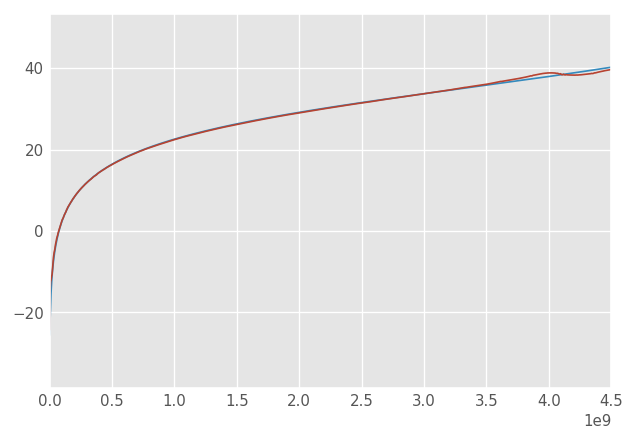

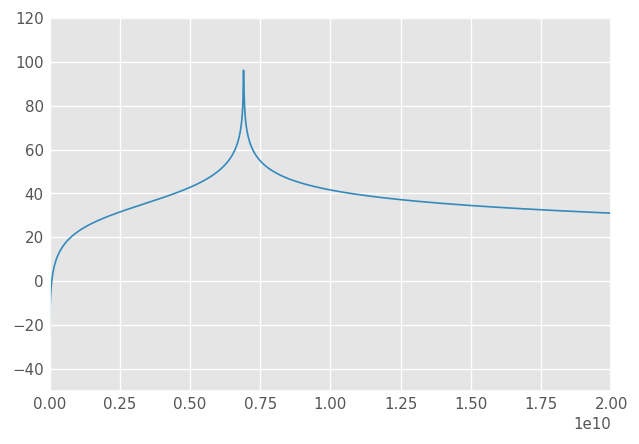

In [7]:
# Characterization of the SMA dummy short (model fitting)
sma_dummy_short_s_params_measured = rf.Network('data/sma_dummy_short.S2P')

measured_freqs_omega = sma_dummy_short_s_params_measured.frequency.w 
measured_freqs_f = np.divide(measured_freqs_omega, 2 * np.pi)

measured_S11 =  sma_dummy_short_s_params_measured.s[:,0,0]
measured_Z11 = np.multiply(50, (np.add(1, measured_S11)) / (np.subtract(1, measured_S11)))

def sma_dummy_short_z11_loss_fn(var, plot=False):
    print(var)
    C_sma = np.tile(var[0], len(measured_freqs_f))
    L_sma = np.tile(var[1], len(measured_freqs_f))
    R_sma = np.tile(var[2], len(measured_freqs_f))
    Z11_model = sma_dummy_short_Z11_model(measured_freqs_omega, C_sma, L_sma, R_sma)
    if plot:
        plt.figure()
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(Z11_model)))
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(measured_Z11)))
    MSE = (1.0 / len(measured_freqs_f)) * np.sum(np.abs(np.square(np.subtract(np.log10(Z11_model), np.log10(measured_Z11)))))
    print(MSE)
    return MSE

sma_dummy_short_z11_loss_fn([0.254e-12, 2.0877e-9, 51.7e-3], plot=True)
scipy.optimize.minimize(sma_dummy_short_z11_loss_fn, (1e-12, 1e-9, 100e-3), method='Nelder-Mead')
plt.figure()
freqs = np.linspace(100e3, 20e9, 1000)
plt.plot(freqs, 20*np.log10([sma_dummy_short_Z11_model(freq*2*np.pi, 0.254e-12, 2.0877e-9, 51.7e-3) for freq in freqs]))